## 1 - Conducting the experiment from a local machine

We'll start with a simple case / base case - requesting the static files from our local machine. As this experiment investigates the response times from within the Singapore region, you need to be located in Singapore for this run to be valid. If you are not located in Singapore, you may use a VPN (see subsequent jupyter notebooks) as a proxy.

In [5]:
import config
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

We iterate through each file server in *config.SOURCE* and make 1000 HTTP GET requests for the payload file for each source. The response times and other metrics such as status codes are recorded and written to a csv file in the data folder.

In [ ]:
with open("./data/local-data.csv", "w") as f:

    n=1000
    origin = "local-test" # Request coming from local machine    
    headers = "timestamp,url,server,resp_time,status_code,size,origin"
    f.write(headers)
    f.write("\n")
    
    # Iterate through each mode of serving payload
    for server, url in config.SOURCE.items():    
        for i in range(1000):
            r = requests.get(url)
            timestamp = datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S.%f')
            row = [
                timestamp, 
                url, 
                server, 
                str(r.elapsed.total_seconds()), 
                str(r.status_code), 
                str(len(r.content)), 
                origin
            ]
            f.write(",".join(row))
            f.write("\n")
            print(i, server, r.elapsed.total_seconds(), r.status_code)

## Hypothesis Testing

With the data at hand, we can visualize and conduct a t-test to ascertain if there any significant differences in speeds between the three methods of delivering static content

In [6]:
df = pd.read_csv('./data/local-data.csv')

In [7]:
df['resp_time'] = df['resp_time'] * 1000 # Convert to milliseconds
df['ln_resp_time'] = np.log(df['resp_time']) # Log response times

In [8]:
df[['resp_time','ln_resp_time','server','origin']].sample(5)

,resp_time,ln_resp_time,server,origin
195,63.296,4.147822,CLOUDFRONT,local
2882,11.929,2.478972,NGINX,local
379,59.916,4.092944,CLOUDFRONT,local
2441,12.570,2.531313,NGINX,local
1880,58.267,4.065036,S3,local


### Plotting response times from local machine

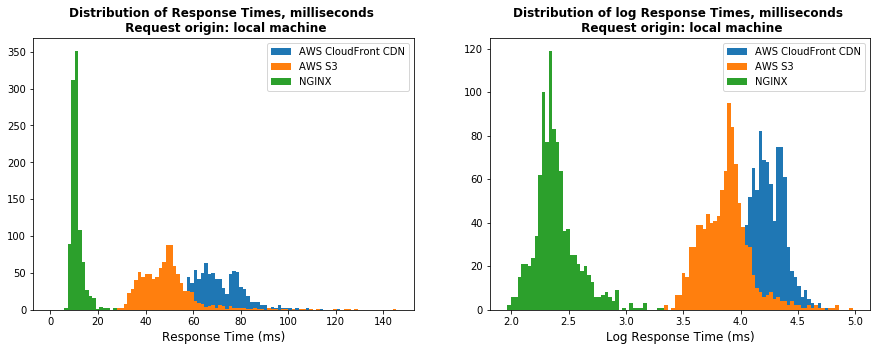

Mean response times (ms): 68.566772 (CloudFront), 49.351551 (S3), 11.131122 (NGINX) 
Variance: 221.79 (CloudFront), 202.14 (S3), 5.87 (NGINX) 
N=3000


In [10]:
cdn, ln_cdn = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='CLOUDFRONT'].values)
s3, ln_s3 = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='S3'].values)
nginx, ln_nginx = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='NGINX'].values)

bins = np.linspace(0, df['resp_time'].quantile(0.999), 100) # Less outliers
ln_bins = np.linspace(df['ln_resp_time'].min(), df['ln_resp_time'].quantile(0.999), 100)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.hist(cdn, bins=bins, label='AWS CloudFront CDN')
ax1.hist(s3, bins=bins, label='AWS S3')
ax1.hist(nginx, bins=bins, label='NGINX')
ax1.set_title('Distribution of Response Times, milliseconds \n Request origin: local machine', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_xlabel("Response Time (ms)", fontsize=12)

ax2.hist(ln_cdn, bins=ln_bins, label='AWS CloudFront CDN')
ax2.hist(ln_s3, bins=ln_bins, label='AWS S3')
ax2.hist(ln_nginx, bins=ln_bins, label='NGINX')
ax2.set_title('Distribution of log Response Times, milliseconds \n Request origin: local machine', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_xlabel("Log Response Time (ms)", fontsize=12)

plt.savefig('./static/local-hist.png')
plt.show()

print(f"Mean response times (ms): {np.mean(cdn)} (CloudFront), {np.mean(s3)} (S3), {np.mean(nginx)} (NGINX) ")
print(f"Variance: {np.var(cdn):.2f} (CloudFront), {np.var(s3):.2f} (S3), {np.var(nginx):.2f} (NGINX) ")
print(f"N={df.shape[0]}")

The results from the figure above are quite surprising. The distribution of response times suggests that the CDN is in fact slower than S3 is delivering the static payload file. In fact, the Nginx file server seems to have the best performance so far, with the lowest variance.

For formality, we will conduct a pairwise t-test for the three delivery methods using a targeted critical value of $\alpha= 0.01$. Applying the bonferroni correction, we get $\alpha_{bonferroni}=0.01/3=0.0033$

The Welch's t-test for unequal variances will be used:

$$ t = \frac{\bar{X_1}-\bar{X_2}}{\sqrt{\frac{s_1^2}{N_1}+\frac{s_2^2}{N_2}}} $$

In [121]:
var_ln_cdn = np.var(ln_cdn, ddof=1)
var_ln_s3 = np.var(ln_s3, ddof=1)
var_ln_nginx = np.var(ln_nginx, ddof=1)

### S3 - CloudFront
$$ H_0:\mu_{S3} = \mu_{CloudFront}$$
$$ H_1:\mu_{S3} \neq \mu_{CloudFront}$$

In [122]:
t, p = stats.ttest_ind(ln_s3, ln_cdn, equal_var = False)
print(f"t score: {t}")
print(f"p-value: {p}")

t score: -37.20724414762849
p-value: 2.3533065364465215e-228


Since the estimated p-value is < than $\alpha_{bonferroni}$, we can reject the null hypothesis that the response times from S3 is equal to that of CloudFront.

### S3 - NGINX
$$ H_0:\mu_{S3} = \mu_{nginx}$$
$$ H_1:\mu_{S3} \neq \mu_{nginx}$$

Now all three environments serving the same file has been deployed. We can run the experiment

In [120]:
t, p = stats.ttest_ind(ln_s3, ln_nginx, equal_var = False)
print(f"t score: {t}")
print(f"p-value: {p}")

t score: 158.75436806449343
p-value: 0.0


Since the estimated p-value is < than $\alpha_{bonferroni}$, we can reject the null hypothesis that the response times from S3 is equal to that of NGINX.

###  NGINX - CloudFront
$$ H_0:\mu_{nginx} = \mu_{CloudFront}$$
$$ H_1:\mu_{nginx} \neq \mu_{CloudFront}$$

In [119]:
t, p = stats.ttest_ind(ln_nginx, ln_cdn, equal_var = False)
print(f"t score: {t}")
print(f"p-value: {p}")

t score: -219.1072594031005
p-value: 0.0


Since the estimated p-value is < than $\alpha_{bonferroni}$, we can reject the null hypothesis that the response times from CloudFront is equal to that of NGINX.

## Discussion

Running the experiment from the local machine (in Singapore) shows surprising results. First, it turns out that accessing the static file payload from a CDN is in fact slower than getting it directly from S3. In addition, retrieving the same file from an Nginx server deployed on an EC2 instance is a lot faster than getting it from S3 or a CDN. 

While the differences are statistically significant, there are still improvements to made to the experimental design. Since these results are generated from a single point location (local machine) in Singapore, it may not  be representative of the typical response times in the region. One improvement would be to record the observations from distributed locations in the region, which will be discussed in the next notebook.

## Comparing speeds from different locations

In [ ]:
df = pd.read_csv("../data/local-data.csv")
df_a = pd.read_csv("../data/ap-southeast-1a-data.csv")
df_b = pd.read_csv("../data/ap-southeast-1b-data.csv")
df_c = pd.read_csv("../data/ap-southeast-1c-data.csv")

In [ ]:
df_az = df_a.append(df_b).append(df_c)


In [ ]:
df_az.shape

In [ ]:
df_az['resp_time'] = df_az['resp_time'] * 1000 # Convert to milliseconds
df_az['ln_resp_time'] = np.log(df_az['resp_time'])

In [ ]:
# Plot distribution of response times from local machine

cdn, ln_cdn = zip(*df_az[['resp_time','ln_resp_time']].loc[df_az['server']=='CLOUDFRONT'].values)
s3, ln_s3 = zip(*df_az[['resp_time','ln_resp_time']].loc[df_az['server']=='S3'].values)
nginx, ln_nginx = zip(*df_az[['resp_time','ln_resp_time']].loc[df_az['server']=='NGINX'].values)

bins = np.linspace(0, df_az['resp_time'].quantile(0.999), 100)
ln_bins = np.linspace(df_az['ln_resp_time'].min(), df_az['ln_resp_time'].quantile(0.999), 100)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.hist(cdn, bins=bins, label='AWS CloudFront CDN')
ax1.hist(s3, bins=bins, label='AWS S3')
ax1.hist(nginx, bins=bins, label='NGINX')
ax1.set_title('Distribution of Response Times, milliseconds \n Request origin: Multi-AZ', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_xlabel("Response Time (ms)", fontsize=12)

ax2.hist(ln_cdn, bins=ln_bins, label='AWS CloudFront CDN')
ax2.hist(ln_s3, bins=ln_bins, label='AWS S3')
ax2.hist(ln_nginx, bins=ln_bins, label='NGINX')
ax2.set_title('Distribution of log Response Times, milliseconds \n Request origin: Multi-AZ', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_xlabel("Response Time (ms)", fontsize=12)


plt.show()

In [ ]:
df_az['resp_time'].loc[(df_az['server']=='NGINX') & (df_az['origin']=='ap-southeast-1a')].mean()

In [ ]:
df_az['resp_time'].loc[(df_az['server']=='NGINX') & (df_az['origin']=='ap-southeast-1b')].mean()

In [ ]:
df_az['resp_time'].loc[(df_az['server']=='NGINX') & (df_az['origin']=='ap-southeast-1c')].mean()

In [ ]:
np.mean(s3)

In [ ]:
np.mean(nginx)

## OLS Regression - AWS AZ

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
df.columns

In [ ]:
# Get server dummies - s3 as base
server_dummies = pd.get_dummies(df_az['server']).drop('S3', axis=1)

# Get Availability Zone dummies - 1a as base
az_dummies = pd.get_dummies(df_az['origin'], drop_first=True)

In [ ]:
df_az = pd.concat([df_az, server_dummies], axis=1)
df_az = pd.concat([df_az, az_dummies], axis=1)

In [ ]:
df_az.rename(columns={
    "ap-southeast-1a" : "ap_southeast_1a",
    "ap-southeast-1b" : "ap_southeast_1b",
    "ap-southeast-1c" : "ap_southeast_1c"
}, inplace=True)

In [ ]:
results = smf.ols("ln_resp_time ~ NGINX + CLOUDFRONT + ap_southeast_1b + ap_southeast_1c ", data=df_az).fit()
print(results.summary())

In [ ]:
100*(np.exp(-0.4016)-1)

In [ ]:
np.exp(-1.9215)*100

## OLS Regression - VPN

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
df.columns

In [ ]:
# Get server dummies - s3 as base
server_dummies = pd.get_dummies(df['server']).drop('S3', axis=1)

# Get Availability Zone dummies - 1a as base
az_dummies = pd.get_dummies(df['origin'], drop_first=True)

In [ ]:
df = pd.concat([df, server_dummies], axis=1)
df = pd.concat([df, az_dummies], axis=1)

In [ ]:
df.rename(columns={
    "sg-vpn-2":"sg_vpn_2",
    "sg-vpn-3" : "sg_vpn_3"
}, inplace=True)

In [ ]:
results = smf.ols("ln_resp_time ~ NGINX + CLOUDFRONT + sg_vpn_2 + sg_vpn_3 ", data=df).fit()
print(results.summary())